# On the Sentence Embeddings from Pre-trained Language Models
# 从预训练语言模型看句子嵌入

Pre-trained contextual representations like BERT have achieved great success in natural language processing. However, the sentence embeddings from the pre-trained language models without fine-tuning have been found to poorly capture semantic meaning of sentences. In this paper, we argue that the semantic information in the BERT embeddings is not fully exploited. We first reveal the theoretical connection between the masked language model pre-training objective and the semantic similarity task theoretically, and then analyze the BERT sentence embeddings empirically. We find that BERT always induces a non-smooth anisotropic semantic space of sentences, which harms its performance of semantic similarity. To address this issue, we propose to transform the anisotropic sentence embedding distribution to a smooth and isotropic Gaussian distribution through normalizing flows that are learned with an unsupervised objective. Experimental results show that our proposed BERT-flow method obtains significant performance gains over the state-of-the-art sentence embeddings on a variety of semantic textual similarity tasks. The code is available at https://github.com/bohanli/BERT-flow.

像BERT这样的预训练的上下文表征在自然语言处理中取得了巨大的成功。然而，从预训练的语言模型中嵌入的句子没有经过微调，很难捕捉句子的语义。本文认为BERT嵌入中的语义信息没有得到充分利用。首先从理论上揭示了masked语言模型预训练目标与语义相似性任务之间的理论联系，然后对BERT语句嵌入进行了实证分析。我们发现，BERT总是会导致句子语义空间的非光滑各向异性，从而影响其语义相似度的表现。为了解决这个问题，我们建议通过规范化无监督目标学习的流，将各向异性句子嵌入分布转化为光滑的各向同性高斯分布。实验结果表明，我们提出的BERT-flow方法在各种语义文本相似性任务上比现有的句子嵌入方法有显著的性能提高。这个代码可在https://github.com/bohanli/BERT-flow.

# 1.Introduction
# 1.简介

Recently, pre-trained language models and its variants (Radford et al., 2019; Devlin et al., 2019; Yang et al., 2019; Liu et al., 2019) like BERT (Devlin et al., 2019) have been widely used as representations of natural language. Despite their great success on many NLP tasks through fine-tuning, the sentence embeddings from BERT without finetuning are significantly inferior in terms of semantic textual similarity (Reimers and Gurevych,2019) – for example, they even underperform the GloVe (Pennington et al., 2014) embeddings which are not contextualized and trained with a much simpler model. Such issues hinder applying BERT sentence embeddings directly to many real-world scenarios where collecting labeled data is highlycosting or even intractable.

最近，像BERT（Devlin等，2019）这样的预训练语言模型及其变体（Radford et al.，2019；Devlin et al.，2019；Yang et al.，2019；Liu et al.，2019）被广泛用于自然语言的表示。尽管通过微调在许多NLP任务中取得了巨大的成功，但是不经过微调的BERT的句子嵌入在语义-文本相似性方面明显较差（Reimers和Gurevych，2019)–例如，他们甚至不如GloVe（Pennington等人，2014年）嵌入的性能，这些嵌入没有经过环境化和更简单的模型训练。这些问题阻碍了将BERT语句嵌入直接应用到许多实际场景中，在这些场景中，收集标记数据的成本很高，甚至很难处理。



In this paper, we aim to answer two major questions: (1) why do the BERT-induced sentence embeddings perform poorly to retrieve semantically similar sentences? Do they carry too little semantic information, or just because the semantic meanings in these embeddings are not exploited properly? (2) If the BERT embeddings capture enough semantic information that is hard to be directly utilized, how can we make it easier without external supervision?

本文旨在回答两个主要问题：（1）为什么BERT诱导的句子嵌入在检索语义相似的句子时表现不佳？它们携带的语义信息太少了，还是仅仅因为这些嵌入中的语义没有被恰当地利用？（2） 如果BERT嵌入捕获了足够多的难以直接利用的语义信息，那么在没有外部监督的情况下，如何才能使其更容易实现呢？


Towards this end, we first study the connection between the BERT pretraining objective and the semantic similarity task. Our analysis reveals that the sentence embeddings of BERT should be able to intuitively reflect the semantic similarity between sentences, which contradicts with experimental observations. Inspired by Gao et al. (2019) who find that the language modeling performance can be limited by the learned anisotropic word embedding space where the word embeddings occupy a narrow cone, and Ethayarajh (2019) who find that BERT word embeddings also suffer from anisotropy, we hypothesize that the sentence embeddings from BERT – as average of context embeddings from last layers– may suffer from similar issues. Through empirical probing over the embeddings, we further observe that the BERT sentence embedding space is semantically non-smoothing and poorly defined in some areas, which makes it hard to be used directly through simple similarity metrics such as dot product or cosine similarity.[1]

为此，我们首先研究了BERT预训练目标与语义相似性任务之间的关系。我们的分析表明，BERT的句子嵌入应该能够直观地反映句子之间的语义相似性，这与实验观察相矛盾。受到Gao等人（2019）的启发，他们发现语言建模的性能会受到学习的各向异性单词嵌入空间的限制，其中单词嵌入占据一个狭窄的圆锥体；Ethayarajh（2019）发现BERT单词嵌入也会受到各向异性的影响，我们假设BERT的句子嵌入（作为最后一层的上下文嵌入的平均值）可能会遇到类似的问题。通过对嵌入的实证研究，**我们进一步发现BERT句子嵌入空间在语义上是非光滑的，并且在某些领域定义不好，这使得它很难直接通过点积或余弦相似性等简单的相似性度量来使用。**


To address these issues, we propose to transform the BERT sentence embedding distribution into a smooth and isotropic Gaussian distribution through normalizing flows (Dinh et al., 2015), which is an invertible function parameterized by neural networks. Concretely, we learn a flow-based generative model to maximize the likelihood of generating BERT sentence embeddings from a standard Gaussian latent variable in a unsupervised fashion. During training, only the flow network is optimized while the BERT parameters remain unchanged. The learned flow, an invertible mapping function between the BERT sentence embedding and Gaussian latent variable, is then used to transform the BERT sentence embedding to the Gaussian space. We name the proposed method as BERT-flow.

为了解决这些问题，**我们建议通过规范化流将BERT语句嵌入分布转换为光滑和各向同性的高斯分布（Dinh等人，2015），这是一个由神经网络参数化的可逆函数。**具体地说，我们学习了一个基于流的生成模型，以最大化无监督方式从标准高斯潜变量生成BERT语句嵌入的可能性。在训练过程中，只对流量网络进行优化，而BERT参数保持不变。然后利用学习流，即BERT语句嵌入与高斯潜在变量之间的一个可逆映射函数，将BERT语句嵌入转换到高斯空间。我们将这种方法命名为BERT-flow。


We perform extensive experiments on 7 standard semantic textual similarity benchmarks without using any downstream supervision. Our empirical results demonstrate that the flow transformation is able to consistently improve BERT by up to 12.70 points with an average of 8.16 points in terms of Spearman correlation between cosine embedding similarity and human annotated similarity. When combined with external supervision from natural language inference tasks (Bowman et al., 2015; Williams et al., 2018), our method outperforms the sentence-BERT embeddings (Reimers and Gurevych, 2019), leading to new state-of-theart performance. In addition to semantic similarity tasks, we apply sentence embeddings to a question-answer entailment task, QNLI (Wang et al., 2019), directly without task-specific supervision, and demonstrate the superiority of our approach. Moreover, our further analysis implies that BERT-induced similarity can excessively correlate with lexical similarity compared to semantic similarity, and our proposed flow-based method can effectively remedy this problem.

我们在7个标准的语义文本相似度基准上进行了大量的实验，没有使用任何下游监督。实验结果表明，在余弦嵌入相似度和人类注释相似度之间的Spearman相关性方面，流变换能够持续地将BERT提高12.70个点，平均8.16个点。当结合来自自然语言推理任务的外部监督（Bowman et al.，2015；Williams et al.，2018），我们的方法优于句子BERT embeddings（Reimers and Gurevych，2019），导致了新的艺术表现。另外，我们还运用了任务相似性的方法，即无需监督任务，直接运用任务的语义监督方法。此外，我们进一步的分析表明，与语义相似度相比，BERT诱导的相似度与词汇相似度之间存在过度的相关性，我们提出的基于流的方法能够有效地解决这一问题。

# 2.Understanding the Sentence Embedding Space of BERT
# 2.理解BERT的句子嵌入空间

To encode a sentence into a fixed-length vector with BERT, it is a convention to either compute an average of context embeddings in the last few layers of BERT, or extract the BERT context embedding at the position of the [CLS] token. Note that there is no token masked when producing sentence embeddings, which is different from pretraining.

为了用BERT将一个句子编码成一个固定长度的向量，一个惯例是计算BERT最后几层中上下文嵌入的平均值，或者在[CLS]标记的位置提取BERT上下文嵌入。需要注意的是，在生成句子嵌入时，没有token masked，这与预训练不同。

Reimers and Gurevych (2019) demonstrate that such BERT sentence embeddings lag behind the state-of-the-art sentence embeddings in terms of semantic similarity. On the STS-B dataset, BERT sentence embeddings are even less competitive to averaged GloVe (Pennington et al., 2014) embeddings, which is a simple and non-contextualized baseline proposed several years ago. Nevertheless, this incompetence has not been well understood yet in existing literature.

Reimers和Gurevych（2019）证明了这种BERT句子嵌入在语义相似性方面落后于最先进的句子嵌入。在STS-B数据集上，BERT句子嵌入比平均GloVe（Pennington et al.，2014）嵌入更不具竞争力，后者是几年前提出的一个简单的非语境化基线。然而，这种无能在现有文献中还没有得到很好的理解。

Note that as demonstrated by Reimers and Gurevych (2019), averaging context embeddings consistently outperforms the [CLS] embedding. Therefore, unless mentioned otherwise, we use average of context embeddings as BERT sentence embeddings and do not distinguish them in the rest of the paper.

通过嵌入[2019]和ReiCh的嵌入，持续证明了[ReiCh]的嵌入效果。因此，除非另有说明，我们将语境嵌入的平均值作为BERT句子嵌入，而在本文的其余部分中，我们没有对它们进行区分。

## 2.1 The Connection between Semantic Similarity and BERT Pre-training
## 2.1语义相似度与BERT预训练的关系

We consider a sequence of tokens x1:T = (x1, . . . , xT ). Language modeling (LM) factorizes the joint probability  p(x1:T )in an autoregressive way, namely  log p(x1:T ) = sigma log p(xt|ct) where the context ct= x1:t−1. To capture bidirectional context during pretraining, BERT proposes a masked language modeling (MLM) objective, which instead factorizes the probability of noisy reconstruction, where xˆ is a corrupted sequence, ˆx is the masked tokens, is equal to 1 when is masked and 0 otherwise. The context ct = ˆx.

我们考虑一个tokens序列x1:T = (x1, . . . , xT )。语言建模（LM）分解联合概率 p(x1:T )以自回归的方式 log p(x1:T ) = sigma log p(xt|ct)，即上下文计算机断层扫描ct= x1:t−1. 为了在预训练过程中捕获双向上下文，BERT提出了一种掩蔽语言建模（MLM）目标，该目标将噪声重构的概率因子化，其中十ˆ是一个损坏的序列，是掩码标记，被屏蔽时等于1，否则等于0。上下文ct = ˆx.。

Note that both LM and MLM can be reduced to modeling the conditional distribution of a token given the context , which is typically formulated with a softmax function as,

注意，LM和MLM都可以简化为对给定上下文的令牌的条件分布进行建模，上下文通常用softmax函数表示为，

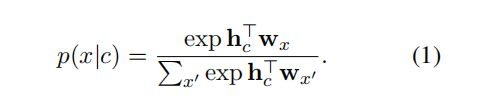

Here the context embedding is a function of , which is usually heavily parameterized by a deep neural network (e.g., a Transformer (Vaswani et al., 2017)); The word embedding is a function of , which is parameterized by an embedding lookup table.


这里，上下文嵌入是的一个函数，通常由深层神经网络（例如，Transformer（Vaswani et al.，2017））进行了大量参数化；单词嵌入是的函数，它通过嵌入查找表进行参数化。

The similarity between BERT sentence embeddings can be reduced to the similarity between BERT context embeddingsh. However, asshown in Equation 1, the pretraining of BERT does not explicitly involve the computation ofhhh. Therefore, we can hardly derive a mathematical formulation of what hcThc exactly represents.


BERT语句嵌入之间的相似性可以归结为BERT上下文嵌入之间的相似性. 然而，作为如等式1所示，BERT的预训练没有显式地涉及到. 因此，我们很难推导出数学公式。

**Co-Occurrence Statistics as the Proxy for Semantic Similarity** Instead of directly analyzinghhhwh, we consider, the dot product between a context embedding and a word embedding . According to Yang et al. (2018), in a well-trained language model,hcwx can be approximately decomposed as follows,

**共现统计代替直接分析作为语义相似度的代理**，我们考虑，上下文嵌入和单词嵌入之间的点积。根据Yang等人（2018），在一个训练有素的语言模型中，hcwx 可以大致分解如下：

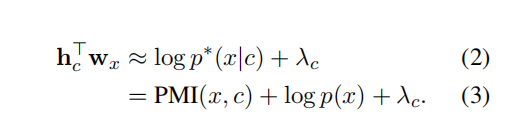

where PMI denotes the pointwise mutual information betweenxand , logp(x) is a word-specific term, and is a context-specific term.

其中PMI表示十术语是特定的，而log p(x)是特定的λc

PMI captures how frequently two events cooccur more than if they independently occur. Note that co-occurrence statistics is a typical tool to deal with “semantics” in a computational way - specifically, PMI is a common mathematical surrogate to approximate word-level semantic similarity (Levy and Goldberg, 2014; Ethayarajh et al., 2019). Therefore, roughly speaking, it is semantically meaningful to compute the dot product between a context embedding and a word embedding.

PMI捕捉到两个事件比它们独立发生时更频繁地发生。请注意，共现统计是一种典型的以计算方式处理“语义”的工具—具体来说，PMI是一种用于近似单词级语义相似性的常用数学替代物（Levy and Goldberg，2014；Ethayarajh et al.，2019）。因此，粗略地说，计算上下文嵌入和单词嵌入之间的点积在语义上是有意义的。

Higher-Order Co-Occurrence Statistics as Context-Context Semantic Similarity. During pretraining, the semantic relationship between two contexts and could be inferred and reinforced with their connections to words. To be specific, if both the contexts and co-occur with the same word , the two contexts are likely to share similar semantic meaning. During the training dynamics, when and occur at the same time, the embeddings and are encouraged to be closer to each other, meanwhile the embedding hc and xw are encouraged to be away from each other due to normalization. A similar scenario applies to the context . In this way, the similarity between hc and xw is also promoted. With all the words in the vocabulary acting as hubs, the context embeddings should be aware of its semantic relatedness to each other.

高阶共现统计作为上下文-上下文语义相似度。在预训练过程中，两个语境和之间的语义关系可以通过与单词的连接来推断和强化。具体地说，如果两个语境和同一个词同时出现，那么两个语境就可能具有相似的语义。在训练动力学中，当和同时发生时，鼓励嵌入和彼此靠近，同时鼓励嵌入hc和xw处由于规范化而彼此远离。类似的场景也适用于上下文。这样，也提高了hc和xw之间的相似性。由于词汇中的所有词汇都是中心词，语境嵌入者应该意识到其语义关联性。

Higher-order context-context co-occurrence could also be inferred and propagated during pretraining. The update of a context embedding could affect another context embedding hc in the above way, and similarly 0 can further affect another. Therefore, the context embeddings can form an implicit interaction among themselves via higher-order co-occurrence relations.

高阶上下文-上下文共现现象也可以在预训练期间被推断和传播。上下文嵌入的更新可能会以上述方式影响另一个上下文嵌入hc，类似地，0可以进一步影响另一个hc。因此，语境嵌入可以通过高阶共现关系在它们之间形成一种隐含的交互作用。

## 2.2 Anisotropic Embedding Space Induces Poor Semantic Similarity
## 2.2嵌入空间的各向异性导致语义相似度较差


As discussed in Section 2.1, the pretraining of BERT should have encouraged semantically meaningful context embeddings implicitly. Why BERT sentence embeddings without finetuning yield unsatisfactory performance?

正如第2.1节所讨论的，BERT的预训练应该隐含地鼓励语义上有意义的上下文嵌入。为什么不经过微调的误码句嵌入效果不理想？

To investigate the underlying problem of the failure, we use word embeddings as a surrogate because words and contexts share the same embedding space. If the word embeddings exhibits some misleading properties, the context embeddings will also be problematic, and vice versa.

因为我们使用代词空间来研究代词嵌入的问题。如果嵌入这个词表现出一些误导性的属性，那么上下文嵌入也会有问题，反之亦然。

Gao et al. (2019) and Wang et al. (2020) have pointed out that, for language modeling, the maximum likelihood training with Equation 1 usually produces an anisotropic word embedding space. “Anisotropic” means word embeddings occupy a narrow cone in the vector space. This phenomenon is also observed in the pretrained Transformers like BERT, GPT-2, etc (Ethayarajh, 2019).

Gao et al.（2019）和Wang et al.（2020）指出，对于语言建模，等式1的最大似然训练通常会产生一个各向异性的单词嵌入空间。“各向异性”是指单词嵌入在向量空间中占据一个狭窄的圆锥体。这种现象也在预培训变压器中观察到，如BERT、GPT-2等（Ethayarajh，2019）。

In addition, we have two empirical observations over the learned anisotropic embedding space.


此外，我们对所学习的各向异性嵌入空间进行了两次经验观测。

**Observation 1: Word Frequency Biases the Embedding Space** We expect the embeddinginduced similarity to be consistent to semantic similarity. If embeddings are distributed in different regions according to frequency statistics, the induced similarity is not useful any more.

**观察1：词频偏移嵌入空间**，我们期望嵌入诱导的相似性与语义相似性一致。如果嵌入数据按照频率统计分布在不同的区域，那么所得到的相似性就不再有用了。

However, as discussed by Gao et al. (2019), anisotropy is highly relevant to the imbalance of word frequency. They prove that under some assumptions, the optimal embeddings of nonappeared tokens in Transformer language models can be extremely far away from the origin. They also try to roughly generalize this conclusion to rarely-appeared words.

然而，正如Gao et al.（2019）所讨论的，各向异性与词频不平衡高度相关。他们证明了在某些假设下，Transformer语言模型中非附加标记的最佳嵌入可能离源极远。他们还试图将这个结论大致概括为很少出现的词语。

To verify this hypothesis in the context of BERT, we compute the mean distance between the BERT word embeddings and the origin (i.e., the mean -norm). In the upper half of Table 1, we observe that high-frequency words are all close to the origin, while low-frequency words are far away from the origin.

为了在BERT上下文中验证这一假设，我们计算了BERT单词嵌入与原点之间的平均距离（即平均范数）。在表1的上半部分，我们观察高频词都接近而低频词则远离词源。

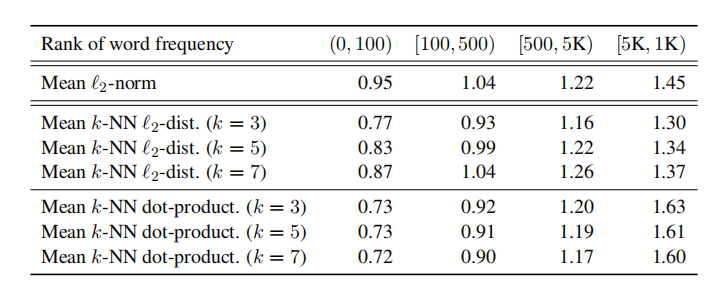

Table 1: The mean -norm, as well as their distance to their -nearest neighbors (among all the word embeddings) of the word embeddings of BERT, segmented by ranges of word frequency rank (counted based on Wikipedia dump; the smaller the more frequent).

表1：根据词频等级范围（根据维基百科统计）对BERT的单词嵌入进行平均范数，以及它们到最近邻的距离（在所有单词嵌入中）倾倒；越小越频繁）。

This observation indicates that the word embeddings can be biased to word frequency. This coincides with the second term in Equation 3, the log density of words. Because word embeddings play a role of connecting the context embeddings during training, context embeddings might be misled by the word frequency information accordingly and its preserved semantic information can be corrupted.

这个观察结果表明，单词嵌入可能会偏向于词频。这与方程式3中的第二项，字的对数密度相吻合。由于单词嵌入在训练过程中起着连接上下文嵌入的作用，因此上下文嵌入可能会被词频信息误导，从而破坏其保留的语义信息。

**Observation 2: Low-Frequency Words Disperse Sparsely** We observe that, in the learned anisotropic embedding space, high-frequency words concentrates densely and low-frequency words disperse sparsely.

**观察2：低频词稀疏分散** 我们观察到，在所学的各向异性嵌入空间中，高频词密集集中，低频词稀疏分散。



This observation is achieved by computing the mean distance of word embeddings to their -nearest neighbors. In the lower half of Table 1, we observe that the embeddings of lowfrequency words tends to be farther to their NN neighbors compared to the embeddings of high-frequency words. This demonstrates that lowfrequency words tends to disperse sparsely.

这种观察是通过计算单词嵌入到最近邻的平均距离来实现的。在表1的下半部分，我们观察到低频词的嵌入比高频词的嵌入更靠近其NN邻居。这说明低频词趋向于稀疏分散。

Due to the sparsity, many “holes” could be formed around the low-frequency word embeddings in the embedding space, where the semantic meaning can be poorly defined. Note that BERT sentence embeddings are produced by averaging the context embeddings, which is a convexitypreserving operation. However, the holes violate the convexity of the embedding space. This is a common problem in the context of representation learining (Rezende and Viola, 2018; Li et al., 2019; Ghosh et al., 2020). Therefore, the resulted sentence embeddings can locate in the poorly-defined areas, and the induced similarity can be problematic.

由于嵌入空间的稀疏性，在嵌入空间中低频词嵌入的周围会形成许多“洞”，语义难以界定。注意，BERT语句嵌入是通过平均上下文嵌入来生成的，这是一个凸保留操作。然而，空穴破坏了嵌入空间的凸性。这是表象学习中的一个常见问题（Rezende和Viola，2018；Li等人，2019；Ghosh等人，2020）。因此，所得到的句子嵌入可以定位在定义不明确的区域，由此产生的相似性也会产生问题。

Figure 1: An illustration of our proposed flow-based calibration over the original sentence embedding space of BERT.

图1：我们提议的基于流的校准在BERT的原始句子嵌入空间上的一个例子。
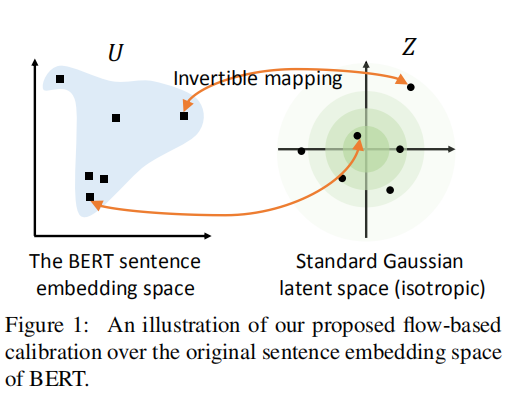

# 3 Proposed Method: BERT-flow
# 3提出的方法：BERT-flow

To verify the hypotheses proposed in Section 2.2, and to circumvent the incompetence of the BERT sentence embeddings, we proposed a calibration method called BERT-flow in which we take advantage of an invertible mapping from the BERT embedding space to a standard Gaussian latent space. The invertibility condition assures that the mutual information between the embedding space and the data examples does not change.

为了验证第2.2节提出的假设，并避免BERT语句嵌入的不足，我们提出了一种称为BERT-flow的校准方法，该方法利用了从BERT嵌入空间到标准高斯潜空间的可逆映射。可逆性条件保证了嵌入空间与数据实例之间的互信息不变。

## 3.1 Motivation
## 3.1动机


A standard Gaussian latent space may have favorable properties which can help with our problem.

一个标准的高斯潜在空间可能有一些有利的性质，可以帮助我们的问题。

**Connection to Observation 1** First, standard Gaussian satisfies isotropy. The probabilistic density in standard Gaussian distribution does not vary in terms of angle. If the norm of samples from standard Gaussian are normalized to 1, these samples can be regarded as uniformly distributed over a unit sphere.

**观点1** 首先，标准高斯满足各向同性,标准高斯分布中的概率密度不随角度变化。如果标准高斯样本的范数归一化为1，则这些样本可以被视为均匀分布在单位球面上。

We can also understand the isotropy from a singular spectrum perspective. As discussed above, the anisotropy of the embedding space stems from the imbalance of word frequency. In the literature of traditional word embeddings, Mu et al. (2017) discovers that the dominating singular vectors can be highly correlated to word frequency, which misleads the embedding space. By fitting a mapping to an isotropic distribution, the singular spectrum of the embedding space can be flattened. In this way, the word frequency-related singular directions, which are the dominating ones, can be suppressed.

我们也可以从奇异光谱的角度来理解各向同性。如上所述，嵌入空间的各向异性源于词频的不平衡。在传统的单词嵌入文献中，Mu et al.（2017）发现主要的奇异向量与词频高度相关，这误导了嵌入空间。通过将映射拟合到各向同性分布，嵌入空间的奇异谱可以展平。这样，就可以抑制与词频相关的主要奇异方向。

**Connection to Observation 2** Second, the probabilistic density of Gaussian is well defined over the entire real space. This means there are no “hole” areas, which are poorly defined in terms of probability. The helpfulness of Gaussian prior for mitigating the “hole” problem has been widely observed in existing literature of deep latent variable models (Rezende and Viola, 2018; Li et al., 2019; Ghosh et al., 2020).

**观点2** 其次高斯分布的概率密度在整个实空间中得到了很好的定义。这意味着不存在“空洞”区域，这在概率上定义得很差。高斯先验对缓解“空洞”问题的帮助已在现有的深潜变量模型文献中得到广泛观察（Rezende and Viola，2018；Li et al.，2019；Ghosh et al.，2020）。

## 3.2 Flow-based Generative Model
## 3.2基于流的生成模型

We instantiate the invertible mapping with flows.A flow-based generative model (Kobyzev et al., 2019) establishes an invertible transformation from the latent space Z to the observed space U. The generative story of the model is defined as

我们用流实例化可逆映射。基于流的生成模型（Kobyzev et al.，2019）建立了从潜在空间Z到观测空间U的可逆转换。模型的生成故事定义为

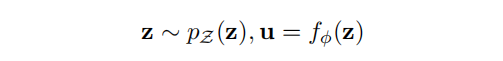

where ∼ pZ(z) the prior distribution, and f : Z → U is an invertible transformation. With the change-of-variables theorem, the probabilistic density function (PDF) of the observable is given as,

其中∼pZ（z）为先验分布，且 f：z→U是可逆变换。利用变元定理，给出了观测值的概率密度函数（PDF)因为，

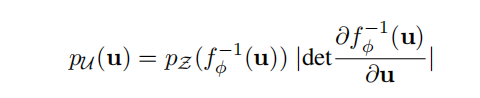

In our method, we learn a flow-based generative model by maximizing the likelihood of generating BERT sentence embeddings from a standard Gaussian latent latent variable. In other words, the base distribution is a standard Gaussian and we consider the extracted BERT sentence embeddings as the observed space U. We maximize the likelihood of U's marginal via Equation 4 in a fully unsupervised way.

在我们的方法中，我们学习了一个基于流的生成模型，通过最大化从标准高斯潜在变量生成BERT语句嵌入的可能性。换言之，基分布是标准高斯分布，我们将提取的BERT语句嵌入作为观测空间U，通过方程4以完全无监督的方式最大化U的边缘可能性。

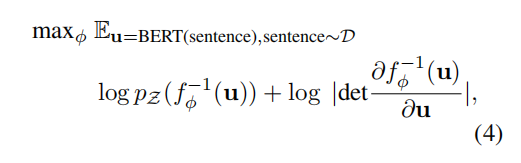

Here D denotes the dataset, in other words, the collection of sentences. Note that during training, only the flow parameters are optimized while the BERT parameters remain unchanged. Eventually, we learn an invertible mapping function which can transform each BERT sentence embedding into a latent Gaussian representation without loss of information.

这里D表示数据集，换句话说，句子集合。注意，在训练过程中，只有流量参数被优化，而BERT参数保持不变。最后，我们学习了一个可逆的映射函数，它可以在不丢失信息的情况下将嵌入的每个BERT语句转换成一个隐高斯表示。

The invertible mapping is parameterized as a neural network, and the architectures are usually carefully designed to guarantee the invertibility (Dinh et al., 2015). Moreover, its determinant should also be easy to compute so as to make the maximum likelihood training tractable. In our experiments, we follows the design of Glow (Kingma and Dhariwal, 2018). The Glow model is composed of a stack of multiple invertible transformations, namely actnorm, invertible 1 × 1 , and affine coupling layer. We simplify the model by replacing affine coupling with additive coupling (Dinh et al., 2015) to reduce model complexity, and replacing the invertible 1×1 convolution with random permutation to avoid numerical errors. For the mathematical formula of the flow model with additive coupling, please refer to Appendix A。

可逆映射被参数化为神经网络，通常精心设计结构以保证可逆性（Dinh等人，2015）。而且，它的决定也应该易于计算，以使最大似然训练易于操作。在我们的实验中，我们遵循辉光的设计(2018年）。辉光模型由多重可逆变换（actnorm、可逆1×1和仿射耦合层）组成。我们通过用加法耦合代替仿射耦合（Dinh et al.，2015）来简化模型，以降低模型复杂性，并用随机置换代替可逆1×1卷积以避免数值误差。加性耦合流动模型的数学公式见附录A。

# 4 Experiments
# 4实验

To verify our hypotheses and demonstrate the effectiveness of our proposed method, in this section we present our experimental results for various tasks related to semantic textual similarity under multiple configurations. For the implementation details of our siamese BERT models and flow-based models, please refer to Appendix B.

为了验证我们的假设并证明我们提出的方法的有效性，在这一节中，我们展示了我们在多种配置下与语义文本相似性相关的各种任务的实验结果。关于我们的暹罗伯特模型和基于流的模型的实现细节，请参阅附录B。

## 4.1 Semantic Textual Similarity
## 4.1语义语篇相似度

**Datasets.** We evaluate our approach extensively on the semantic textual similarity (STS) tasks. We report results on 7 datasets, namely the STS benchmark (STS-B) (Cer et al., 2017) the SICK-Relatedness (SICK-R) dataset (Marelli et al., 2014) and the STS tasks 2012 - 2016 (Agirre et al., 2012, 2013, 2014, 2015, 2016). We obtain all these datasets via the SentEval toolkit (Conneau and Kiela, 2018). These datasets provide a fine-grained gold standard semantic similarity between 0 and 5 for each sentence pair.

**数据集。**我们在语义-文本相似性（STS）任务上对我们的方法进行了广泛的评估。我们报告了7个数据集的结果，即STS基准（STS-B）（Cer等人，2017年）、疾病相关性（SICK-R）数据集（Marelli等人，2014年）和STS任务2012-2016年（Agirre等人，2012年、2013年、2014年、2015年、2016年）。我们通过SentEval工具箱获得所有这些数据集（Conneau和Kiela，2018）。这些数据集为每个句子对提供了0到5之间的细粒度黄金标准语义相似度。

**Evaluation Procedure.** Following the procedure in previous work like Sentence-BERT (Reimers and Gurevych, 2019) for the STS task, the prediction of similarity consists of two steps: (1) first, we obtain sentence embeddings for each sentence with a sentence encoder, and (2) then, we compute the cosine similarity between the two embeddings of the input sentence pair as our model-predicted similarity. The reported numbers are the Spearman's correlation coefficients between the predicted similarity and gold standard similarity scores, which is the same way as in (Reimers and Gurevych, 2019).

**评估程序。**遵循之前工作中的程序，如句子BERT（Reimers和Gurevych，2019）中的STS任务，相似度的计算包括两个步骤：（1）首先用句子编码器获得每个句子的句子嵌入，（2）然后计算输入句子对的两个嵌入之间的余弦相似度作为我们的模型预测相似度。报告的数字是预测相似性和黄金标准相似性得分之间的斯皮尔曼相关系数，与中的方法相同（Reimers和Gurevych，2019）。

**Experimental Details.** We consider both BERT base and BERT large in our experiments. Specifically, we use an average pooling over BERT context embeddings in the last one or two layers as the sentence embedding which is found to outperform the [CLS] vector. Interestingly, our preliminary exploration shows that averaging the last two layers of BERT (denoted by last2avg) consistently produce better results compared to only averaging the last one layer. Therefore, we choose -last2avg as our default configuration when assessing our own approach.

**实验细节。**我们的实验中考虑了BERT base 和 BERT large。具体地说，我们在最后一层或两层的BERT上下文嵌入上使用一个平均池作为句子嵌入，它的性能优于[CLS]向量。有趣的是，我们的初步探索表明，平均最后两层BERT与仅平均最后一层相比，始终可以产生更好的结果。因此，在评估我们自己的方法时，我们选择最后两层作为默认配置。

For the proposed method, the flow-based objective (Equation 4) is maximized only to update the invertible mapping while the BERT parameters remains unchanged. Our flow models are by default learned over the full target dataset (train + validation + test). We denote this configuration as flow (target). Note that although we use the sentences of the entire target dataset, learning flow does not use any provided labels for training, thus it is a purely unsupervised calibration over the BERT sentence embedding space.

对于所提出的方法，在保持BERT参数不变的情况下，基于流的目标（方程4）仅用于更新可逆映射。默认情况下，我们的流模型是通过完整的目标数据集（训练+验证+测试）学习的。我们将此配置表示为流（目标）。注意，虽然我们使用整个目标数据集的句子，但是学习流没有使用任何提供的标签进行训练，因此它是一个纯粹的无监督的校准在BERT句子嵌入空间。

We also test our flow-based model learned on a concatenation of SNLI (Bowman et al., 2015) and MNLI (Williams et al., 2018) for comparison (flow (NLI)). The concatenated NLI datasets comprise of tremendously more sentence pairs (SNLI 570K + MNLI 433K). Note that “flow (NLI)” does not require any supervision label. When fitting flow on NLI corpora, we only use the raw sentences instead of the entailment labels. An intuition behind the flow (NLI) setting is that, compared to Wikipedia sentences (on which BERT is pretrained), the raw sentences of both NLI and STS are simpler and shorter. This means the NLI-STS discrepancy could be relatively smaller than the Wikipedia-STS discrepancy.

我们还测试了基于流的SNLI（Bowman et al.，2015）和MNLI（Williams et al.，2018）的串联模型，以进行比较（flow（NLI））。连接的NLI数据集包含了非常多的句子对（SNLI 570K+MNLI 433K）。注意，“流量（NLI）”不需要任何监管标签。在对NLI语料库进行流拟合时，我们只使用原始句子，而不使用蕴涵标签。在flow（NLI）设置背后的一个直觉是，与Wikipedia语句（BERT是预先训练过的）相比，NLI和STS的原始语句更简单、更短。这意味着NLI-STS的差异可能相对小于维基百科的STS差异。

We run the experiments on two settings: (1) when external labeled data is unavailable. This is the natural setting where we learn flow parameters with the unsupervised objective (Equation 4), meanwhile BERT parameters are unchanged. (2) we first fine-tune BERT on the SNLI+MNLI textual entailment classification task in a siamese fashion (Reimers and Gurevych, 2019). For BERTflow, we further learn the flow parameters. This setting is to compare with the state-of-the-art results which utilize NLI supervision (Reimers and Gurevych, 2019). We denote the two different models as BERT-NLI and BERT-NLI-flow respectively.

我们在两种情况下进行实验：（1）当外部标记数据不可用时。这是我们在无监督目标下学习流参数的自然环境（方程4），同时BERT参数不变。（2） 我们首先以孪生的方式对SNLI+MNLI文本蕴涵分类任务进行微调（Reimers和Gurevych，2019）。对于BERT_flow，我们进一步了解了流动参数。此设置是为了与利用NLI监督的最新结果进行比较（Reimers和Gurevych，2019年）。我们将这两个不同的模型分别表示为BERT-NLI和BERT-NLI流。

**Results w/o NLI Supervision.** As shown in Table 2, the original BERT sentence embeddings(with both BERT_base and BERT_large) fail to outperform the averaged GloVe embeddings.averaging the last-two layers of the BERT model can consistently improve the results. For BERTbase and BERTlarge, our proposed flow-based method (BERT-flow (target)) can further boost the performance by 5.88 and 8.16 points on average respectively. For most of the datasets, learning flows on the target datasets leads to larger performance improvement than on NLI. The only exception is SICK-R where training flows on NLI is better. We think this is because SICK-R is collected for both entailment and relatedness. Since SNLI and MNLI are also collected for textual entailment evaluation, the distribution discrepancy between SICK-R and NLI may be relatively small. Also due to the much larger size of the NLI datasets, it is not surprising that learning flows on NLI results in stronger performance.


**结果无NLI监督。** 如表2所示，原BERT语句嵌入（同时使用BERT_base和BERT_large）未能超过平均GloVe嵌入量。以及对BERT模型的最后两层取平均值可以持续改善结果。对于BERT_base和BERT_large，我们提出的基于流的方法（BERT-flow（target））可以进一步提高性能，平均分别提高5.88和8.16个点。对于大多数数据集，目标数据集上的学习流比NLI上的学习流带来更大的性能改进。唯一的例外是SICK-R，那里的NLI训练效果更好。我们认为这是因为SICK-R是为蕴涵性和关联性而收集的。由于SNLI和MNLI也是用来进行文本蕴涵评价的，SICK-R和NLI之间的分布差异可能相对较小。另外，由于NLI数据集的规模要大得多，因此NLI上的学习流能够产生更强的性能也就不足为奇了。

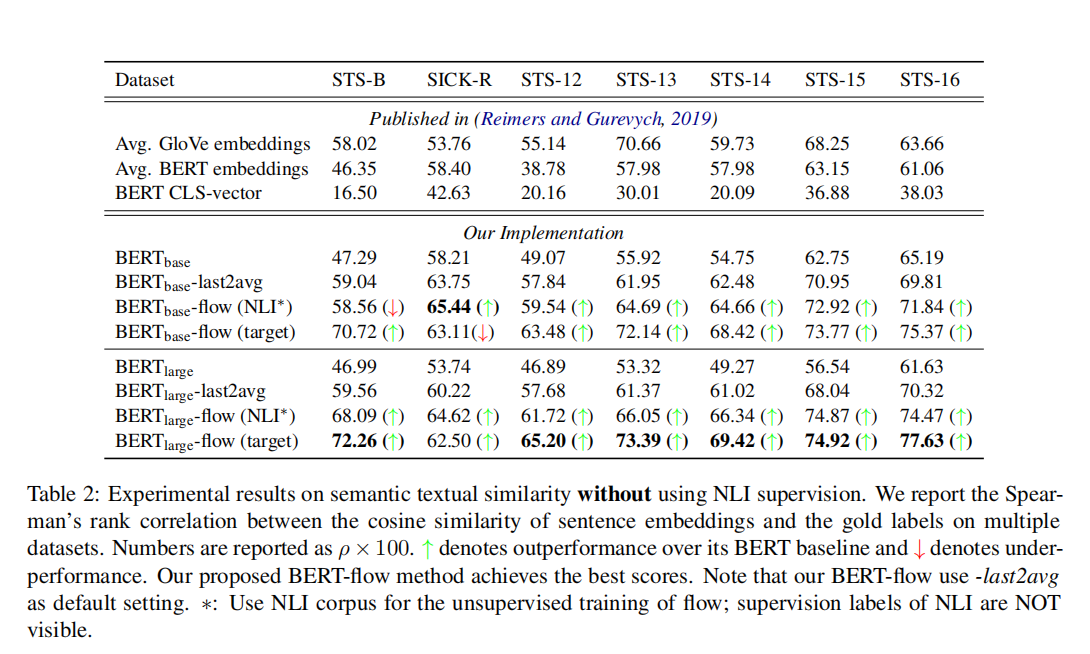

**Results w/NLI Supervision.** Table 3 shows the results with NLI supervisions. Similar to the fully unsupervised results before, our isotropic embedding space from invertible transformation is able to consistently improve the SBERT baselines in most cases, and outperforms the state-of-the-art SBERT/SRoBERTa results by a large margin. Robustness analysis with respect to random seeds are provided in Appendix C.

**结果w/NLI监督。** 表3显示了NLI监督的结果。与之前的完全无监督结果类似，我们的可逆变换的各向同性嵌入空间能够在大多数情况下持续改进SBERT基线，并且在很大程度上优于最新的SBERT/SRoBERTa结果。关于随机种子的稳健性分析见附录C。

## 4.2 Unsupervised Question-Answer Entailment
## 4.2无监督问答

In addition to the semantic textual similarity tasks, we examine the effectiveness of our method on unsupervised question-answer entailment. We use Question Natural Language Inference (QNLI, Wang et al. (2019)), a dataset comprising 110K question-answer pairs (with 5K+ for testing). QNLI extracts the questions as well as their corresponding context sentences from SQUAD (Rajpurkar et al., 2016), and annotates each pair as either entailment or no entailment. In this paper, we further adapt QNLI as an unsupervised task. The similarity between a question and an answer can be predicted by computing the cosine similarity of their sentence embeddings. Then we regard entailment as 1 and no entailment as 0, and evaluate the performance of the methods with AUC.

除了语义-文本相似性任务外，我们还检验了我们的方法在无监督问答蕴涵问题上的有效性。我们使用问题自然语言推理（QNLI，Wang et al.（2019）），这是一个包含110K个问答对的数据集（5K+用于测试）。QNLI从SQUAD中提取问题及其相应的上下文句子（Rajpurkar et al.，2016），并将每对问题注释为包含或不包含。在本文中，我们进一步将QNLI作为一个无监督的任务。通过计算一个问句和一个问句之间的相似性，可以预测出它们之间的相似性。然后，我们将蕴涵量视为1，无牵连为0，并用AUC评价了这些方法的性能。

## 4.3 Comparison with Other Embedding Calibration Baselines
## 4.3与其他埋设的比较校准基线

In the literature of traditional word embeddings,Arora et al. (2017) and Mu et al. (2017) also discover the anisotropy phenomenon of the embedding space, and they provide several methods to encourage isotropy:

在传统的嵌词文学中，Arora et al.（2017）和Mu et al.（2017）也发现了嵌入空间的各向异性现象，他们提供了几种鼓励各向同性的方法：



**Standard Normalization (SN).** In this idea, we conduct a simple post-processing over the embeddings by computing the mean µ and standard deviation σ of the sentence embeddings 's, and normalizing the embeddings by (u-µ)/σ.

标准归一化（SN）。在这个思想中，我们通过计算句子嵌入的平均值µ和标准差σ对嵌入进行简单的后处理，并通过by (u-µ)/σ.


Nulling Away Top-Singular Vectors (NATSV). Mu et al. (2017) find out that sentence embeddings computed by averaging traditional word embeddings tend to have a fast-decaying singular spectrum. They claim that, by nulling away the top-singular vectors, the anisotropy of the embeddings can be circumvented and better semantic similarity performance can be achieved.

消除顶部奇异向量（NATSV）。Mu等人（2017）发现，通过平均传统单词嵌入量计算出的句子嵌入量往往具有快速衰减的奇异谱。他们声称，通过消除顶部奇异向量，可以避免嵌入的各向异性，从而获得更好的语义相似度性能。

We compare with these embedding calibration methods on STS-B dataset and the results are shown in Table 5. Standard normalization (SN) helps improve the performance but it falls behind nulling away top-singular vectors (NATSV). This means standard normalization cannot fundamentally eliminate the anisotropy. By combining the two methods, and carefully tuning over the validation set, further improvements can be achieved.

我们在STS-B数据集上与这些嵌入校准方法进行了比较，结果如表5所示。标准规范化（SN）有助于提高性能，但它落后于消除顶奇异向量（NATSV）。这意味着标准规范化不能从根本上消除各向异性。通过组合这两种方法，并仔细调整验证集，可以实现进一步的改进。

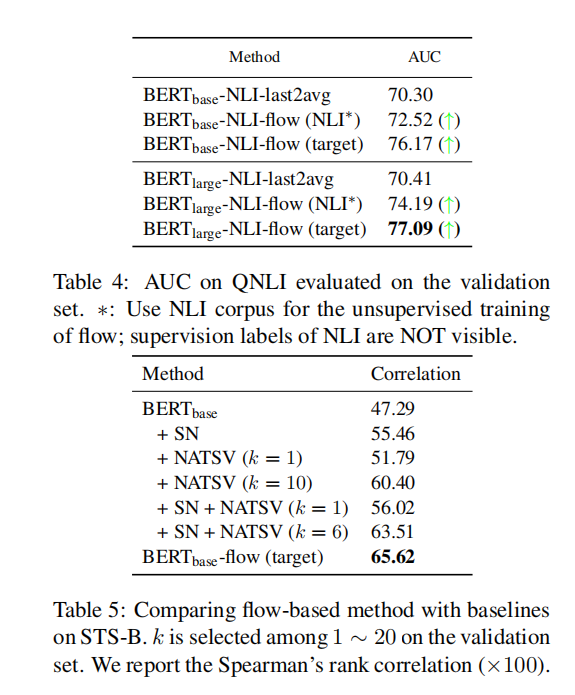

Nevertheless, our method still produces much better results. We argue that NATSV can help eliminate anisotropy but it may also discard some useful information contained in the nulled vectors. On the contrary, our method directly learns an invertible mapping to isotropic latent space without discarding any information.

然而，我们的方法仍能产生更好的结果。我们认为，NATSV可以帮助消除各向异性，但它也可能会丢弃一些有用的信息包含在空向量。相反，我们的方法直接学习到各向同性潜在空间的可逆映射，而不丢失任何信息。

## 4.4 Dicussion: Semantic Similarity Versus Lexical Similarity
## 4.4讨论：语义相似与词汇相似

In addition to semantic similarity, we further study lexical similarity induced by different sentence embeddings. Specifically, we use edit distance as the metric for lexical similarity between a pair of sentences, and focus on the correlations between the sentence similarity and edit distance. Concretely, we compute the cosine similarity in terms of BERT sentence embeddings as well as edit distance for each sentence pair. Within a dataset consisting of many sentence pairs, we compute the Spearman's correlation coefficient between the similarities and the edit distances, as well as between similarities from different models. We perform experiment on the STS-B dataset and include the human annotated gold similarity into this analysis.

除了语义上的相似性，我们还进一步研究了不同句子嵌入所引起的词汇相似性。具体来说，我们使用编辑距离作为一对句子之间词汇相似度的度量标准，并着重研究句子相似度与编辑距离之间的相关性。具体地说，我们计算余弦相似度根据伯特语句嵌入和编辑距离为每个句子对。在由多个句子对组成的数据集中，我们计算相似度与编辑距离以及不同模型相似度之间的Spearman相关系数。我们在STS-B数据集上进行了实验，并将人类标注的gold相似度纳入分析。


**BERT-Induced Similarity Excessively Correlates with Lexical Similarity.** Table 6 shows that the correlation between BERT-induced similarity and edit distance is very strong (= −50.49), considering that gold standard labels maintain a much smaller correlation with edit distance (= −24.61). This phenomenon can also be observed in Figure 2. Especially, for sentence pairs with edit distance ≤ 4 (highlighted with green), BERT induced similarity is extremely correlated to edit distance. However, it is not evident that gold standard semantic similarity correlates with edit distance. In other words, it is often the case where the semantics of a sentence can be dramatically changed by modifying a single word. For example, the sentences “I like this restaurant” and “I dislike this restaurant” only differ by one word, but convey opposite semantic meaning. BERT embeddings may fail in such cases. Therefore, we argue that the lexical proximity of BERT sentence embeddings is excessive, and can spoil their induced semantic similarity.

**BERT诱导的相似性与词汇相似性过度相关。**表6表明，考虑到黄金标准标签与编辑距离保持较小的相关性（pho = -24.61），BERT诱导的相似性与编辑距离之间的相关性非常强（pho = -50.49）。这种现象也可以在图2中观察到。特别是对于编辑距离≤4（用绿色突出显示）的句子对，bert诱导的相似性与编辑距离有着极强的相关性。然而，语义距离与编辑的相关性并不明显。换言之，通常情况下，一个句子的语义可以是戏剧性的通过修改一个单词而改变的。例如，“我喜欢这家餐馆”和“我不喜欢这家餐馆”这两个句子只有一个词的不同，但表达的是相反的语义。在这种情况下，BERT嵌入可能会失败。因此，我们认为BERT句嵌入的词汇接近度过大，会破坏其诱导的语义相似性。

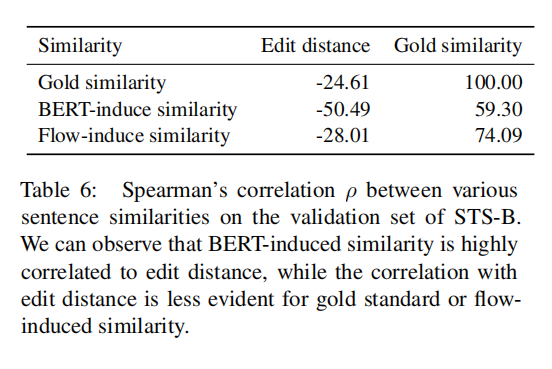

**Flow-Induced Similarity Exhibits Lower Correlation with Lexical Similarity.** By transforming the original BERT sentence embeddings into the learned isotropic latent space with flow, the embedding-induced similarity not only aligned better with the gold semantic semantic similarity, but also shows a lower correlation with lexical similarity, as presented in the last row of Table 6. The phenomenon is especially evident for the examples with edit distance ≤ 4 (highlighted with green in Figure 2). This demonstrates that our proposed flow-based method can effectively suppress the excessive influence of lexical similarity over the embedding space.


流诱导相似性与词汇相似性的相关性较低。通过将原始的BERT句子嵌入转化为学习到的具有流的各向同性潜空间，嵌入诱导的相似性不仅与gold语义相似性更接近，而且与词汇相似性的相关性较低，如表6最后一行所示。这种现象对于编辑距离≤4的示例尤其明显（图2中用绿色突出显示）。这说明我们提出的基于流的方法能够有效地抑制词汇相似度对嵌入空间的过度影响。

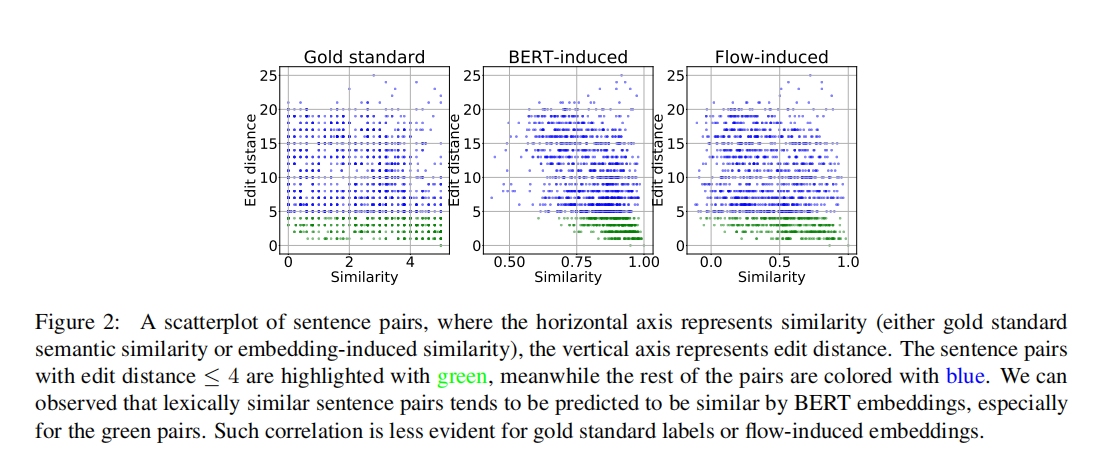

# 5 Conclusion and Future Work
# 5结论和今后的工作

In this paper, we investigate the deficiency of the BERT sentence embeddings on semantic textual similarity, and propose a flow-based calibration which can effectively improve the performance. In the future, we are looking forward to diving in representation learning with flow-based generative models from a broader perspective.

本文针对BERT语句嵌入在语义文本相似度方面的不足，提出了一种基于流的校正方法，可以有效地提高其性能。在未来，我们期待着从更广阔的视角，利用基于流的生成模型进行表征学习。

Acknowledgments
The authors would like to thank Jiangtao Feng,Wenxian Shi, Yuxuan Song, and anonymous reviewers for their helpful comments and suggestion on this paper.

致谢
作者要感谢冯江涛，史文贤、宋宇轩和匿名评论员对本文的有益评论和建议。